# Demo: OpenMX and  DeepMD-kit

Today, I will try to demonstrate how to make a NN potential by using Interface from OpenMX to DeePMD-kit.

Regardless of which DFT calculation software is used, the information shown below must be transmitted to the DeePMD-kit side.

<div style="text-align: center;">【Available properties are (nframe: number of frames in the system, natoms: total number of atoms in the system)】</div>

| key          | type        | dimension            | are labels | description                           |
|--------------|-------------|----------------------|------------|---------------------------------------|
| 'atom_names' | list of str | ntypes               | False      | The name of each atom type            |
| 'atom_numbs' | list of int | ntypes               | False      | The number of atoms of each atom type |
| 'atom_types' | np.ndarray  | natoms               | False      | Array assigning type to each atom     |
| 'cells'      | np.ndarray  | nframes x 3 x 3      | False      | The cell tensor of each frame         |
| 'coords'     | np.ndarray  | nframes x natoms x 3 | False      | The atom coordinates                  |
| 'energies'   | np.ndarray  | nframes              | True       | The frame energies                    |
| 'forces'     | np.ndarray  | nframes x natoms x 3 | True       | The atom forces                       |
| 'virials'    | np.ndarray  | nframes x 3 x 3      | True       | The virial tensor of each frame       |

For more details, please check [dpdata repository](https://github.com/deepmodeling/dpdata/tree/master).

Let's check file behaviors.

```
cd dpdata/openmx
python3 omx.py
```

## How to use (for busy people)

Original `dpdata` doesn't supports OpenMX format at this time (2023/11/28). However, I make it possible. Please run the following command.

In [14]:
import dpdata
data = dpdata.LabeledSystem(f'10.data/Methane', fmt = 'openmx')
print('# the data contains %d frames' % len(data))

# the data contains 200 frames


## Sample files description

1. `00.data` CH4 with ABACUS (, CP2K, or VASP)
2. `10.data` CH4 with OpenMX

Each folder named `train` contains `input.json`, deepmd-kit input script.

1. `01.train` CH4 with ABACUS (, CP2K, or VASP)
1. `11.train` CH4 with OpenMX

The package named `dpdata` supports `fmt="openmx"`.

Each file name means the following.

1. abacus is ABACUS results
2. openmx is OpenMX results
3. abacus_nn is NN potential results made with ABACUS
4. openmx_nn is NN potential results made with OpenMX

Please check each folder.

1. `gif` contains DPMD animation
1. `img` contains image of each system
1. `log` contains logs of DPMD calculation, like temperature, P.E., etc.
2. `traj` contains trajectories of DPMD calculation

You can run MD calculation with ASE by using `CH4_MD.py`.

## How to prepare for OpenMX format (minimum required)

To prepare minimum required, place the original `dpdata` on the working directory, and place a file named `openmx.py` and a folder named `openmx`, which contains `__init__.py` and `omx.py`, in the _appropriate location_.

Note: The easiest way to prepare is probably to use the Finder or something similar managers to get the folder arrangement just right anyway.

In [15]:
! tree dpdata/openmx

dpdata/openmx
├── __init__.py
├── __pycache__
│   ├── __init__.cpython-311.pyc
│   └── omx.cpython-311.pyc
└── omx.py

2 directories, 4 files


```
openmx
├── __init__.py
├── __pycache__
│   ├── __init__.cpython-311.pyc
│   └── omx.cpython-311.pyc
└── omx.py

2 directories, 4 files

```
is correct.

In [16]:
! tree dpdata/plugins

dpdata/plugins
├── 3dmol.py
├── __init__.py
├── __pycache__
│   ├── 3dmol.cpython-311.pyc
│   ├── __init__.cpython-311.pyc
│   ├── abacus.cpython-311.pyc
│   ├── amber.cpython-311.pyc
│   ├── ase.cpython-311.pyc
│   ├── cp2k.cpython-311.pyc
│   ├── deepmd.cpython-311.pyc
│   ├── dftbplus.cpython-311.pyc
│   ├── fhi_aims.cpython-311.pyc
│   ├── gaussian.cpython-311.pyc
│   ├── gromacs.cpython-311.pyc
│   ├── lammps.cpython-311.pyc
│   ├── list.cpython-311.pyc
│   ├── openmx.cpython-311.pyc
│   ├── psi4.cpython-311.pyc
│   ├── pwmat.cpython-311.pyc
│   ├── pymatgen.cpython-311.pyc
│   ├── qe.cpython-311.pyc
│   ├── rdkit.cpython-311.pyc
│   ├── siesta.cpython-311.pyc
│   ├── vasp.cpython-311.pyc
│   └── xyz.cpython-311.pyc
├── abacus.py
├── amber.py
├── ase.py
├── cp2k.py
├── deepmd.py
├── dftbplus.py
├── fhi_aims.py
├── gaussian.py
├── gromacs.py
├── lammps.py
├── list.py
├── openmx.py
├── psi4.py
├── pwmat.py
├── pymatgen.py
├── qe.py
├── rdkit.py
├── siesta.py
├── vasp.py
└── xyz.py



```
plugins
├── 3dmol.py
├── __init__.py
├── __pycache__
│   ├── 3dmol.cpython-311.pyc
│   ├── __init__.cpython-311.pyc
│   ├── abacus.cpython-311.pyc
│   ├── amber.cpython-311.pyc
│   ├── ase.cpython-311.pyc
│   ├── cp2k.cpython-311.pyc
│   ├── deepmd.cpython-311.pyc
│   ├── dftbplus.cpython-311.pyc
│   ├── fhi_aims.cpython-311.pyc
│   ├── gaussian.cpython-311.pyc
│   ├── gromacs.cpython-311.pyc
│   ├── lammps.cpython-311.pyc
│   ├── list.cpython-311.pyc
│   ├── openmx.cpython-311.pyc
│   ├── psi4.cpython-311.pyc
│   ├── pwmat.cpython-311.pyc
│   ├── pymatgen.cpython-311.pyc
│   ├── qe.cpython-311.pyc
│   ├── rdkit.cpython-311.pyc
│   ├── siesta.cpython-311.pyc
│   ├── vasp.cpython-311.pyc
│   └── xyz.cpython-311.pyc
├── abacus.py
├── amber.py
├── ase.py
├── cp2k.py
├── deepmd.py
├── dftbplus.py
├── fhi_aims.py
├── gaussian.py
├── gromacs.py
├── lammps.py
├── list.py
├── openmx.py
├── psi4.py
├── pwmat.py
├── pymatgen.py
├── qe.py
├── rdkit.py
├── siesta.py
├── vasp.py
└── xyz.py

2 directories, 44 files
```
is correct.

## How to prepare for OpenMX format (from command line)

Assuming that "tensorflow" and "deepmd-kit" is pre-installed. 

In [ ]:
# ! pip install tensorflow
# ! pip install deepmd-kit

Please download sample files.

In [1]:
# ! git clone https://github.com/shigeandtomo/Demo work

Cloning into 'Demo'...
remote: Enumerating objects: 571, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 571 (delta 5), reused 13 (delta 3), pack-reused 556
Receiving objects: 100% (571/571), 549.46 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Updating files: 100% (353/353), done.


In [7]:
! ls

00.data               Cdia_MD.py            demo.ipynb
01.train              Cdia_curve.png        demo_additional.ipynb
10.data               Graphite.gif          dpdata
11.train              Graphite.traj         file.sh
20.data               Graphite_MD.py        geometry
21.train              Graphite_curve.png    geometry.py
30.data               H2O.gif               gif
31.train              H2O.log               img
40.data               H2O.traj              log
41.train              H2O.txt               omx2qe.py
CH4.gif               H2O_MD.py             omxfile.sh
CH4.traj              H2O_nn.txt            openmx.txt
CH4.txt               Methane.txt           openmx_nn.txt
CH4_MD.py             README.md             train.sh
Cdia.gif              __pycache__           traj
Cdia.png              abacus.txt
Cdia.traj             abacus_nn.txt


In [3]:
# import os
# os.chdir("work")

In [3]:
# ! git clone https://github.com/deepmodeling/dpdata tmp

In [ ]:
# ! cp -r tmp/dpdata .

In [2]:
# ! cp -r openmx dpdata/
# ! cp openmx.py dpdata/plugins/

cp: openmx: No such file or directory
cp: openmx.py: No such file or directory


## Import libraries

Now, we can use deepmd with OpenMX. Then, import the following libraries.

In [18]:
import os
import dpdata
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ang2bohr = 1.88972612463
bohr2ang = 0.529177210903

### Note: Even if "dpdata" has already been installed, the package named "dpdata" in the current directory is imported first.

## Table of contents

The demonstration with ABACUS from [DeePMD-kit Quick Start Tutorial](https://docs.deepmodeling.com/projects/deepmd/en/master/getting-started/quick_start.html)
1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
2. [Data preparation](#scrollTo=G-laa4YqQRji)
3. [Prepare input script](#scrollTo=G-laa4YqQRji)
4. [Train a model](#scrollTo=G-laa4YqQRji)
5. [Test a model](#scrollTo=G-laa4YqQRji)
6. [Run MD with ASE](#scrollTo=G-laa4YqQRji)

The demonstration with OpenMX
1. [Get DFT data](#scrollTo=zEltPNkLuLz6) 
2. [Data preparation](#scrollTo=G-laa4YqQRji)
3. [Prepare input script](#scrollTo=G-laa4YqQRji)
4. [Train a model](#scrollTo=G-laa4YqQRji)
5. [Test a model](#scrollTo=G-laa4YqQRji)
6. [Run MD with ASE](#scrollTo=G-laa4YqQRji)
7. [Run structure optimization with ASE]()

【Known problems】

【Linkage to tools】

## The demonstration with ABACUS from [DeePMD-kit Quick Start Tutorial](https://docs.deepmodeling.com/projects/deepmd/en/master/getting-started/quick_start.html)

You can see the official tutorial from the URL. I will explain ABACUS format in brief.

### 1.Get DFT data

#### First, plot bond length and angles in the data from ABACUS.

length mean value = 1.10, angle mean value = 109.79


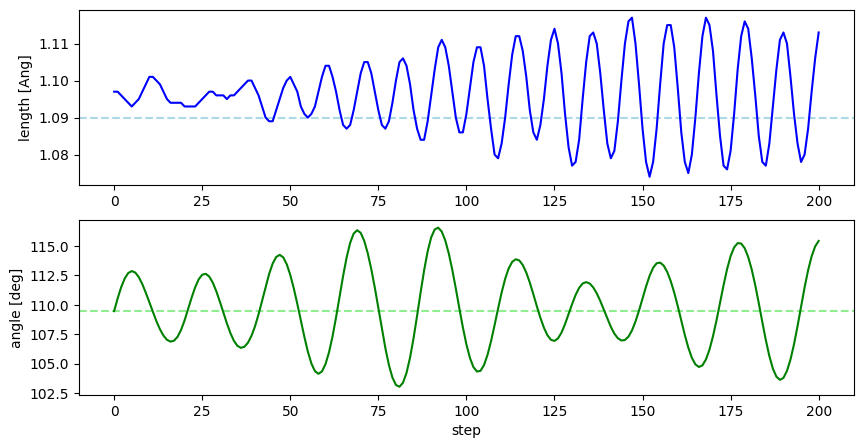

In [ ]:
### ABACUS data plot ###
data=np.genfromtxt("abacus.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(1000,2000)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(1000,2000)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,4], color="green")

print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,4].mean():3.2f}")
# plt.savefig("abacus.png")
plt.show()

### 2.Data preparation 

In [ ]:
# load data of abacus/md format
data = dpdata.LabeledSystem("00.data/abacus_md", fmt="abacus/md")
print("# the data contains %d frames" % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(201, size=40, replace=False)

# other indexes are training_data
index_training = list(set(range(201)) - set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# all training data put into directory:"training_data"
data_training.to_deepmd_npy("00.data/abacus_md/training_data")

# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy("00.data/abacus_md/validation_data")

print("# the training data contains %d frames" % len(data_training))
print("# the validation data contains %d frames" % len(data_validation))

# the data contains 201 frames
# the training data contains 161 frames
# the validation data contains 40 frames


### 3.Prepare input script

In [5]:
! cat 01.train/input.json

{
    "_comment": " model parameters",
    "model": {
	"type_map":	["H", "C"],
	"descriptor" :{
	    "type":		"se_e2_a",
	    "sel":		"auto",
	    "rcut_smth":	0.50,
	    "rcut":		6.00,
	    "neuron":		[25, 50, 100],
	    "resnet_dt":	false,
	    "axis_neuron":	16,
	    "seed":		1,
	    "_comment":		" that's all"
	},
	"fitting_net" : {
	    "neuron":		[240, 240, 240],
	    "resnet_dt":	true,
	    "seed":		1,
	    "_comment":		" that's all"
	},
	"_comment":	" that's all"
    },

    "learning_rate" :{
	"type":		"exp",
	"decay_steps":	50,
	"start_lr":	0.001,	
	"stop_lr":	3.51e-8,
	"_comment":	"that's all"
    },

    "loss" :{
	"type":		"ener",
	"start_pref_e":	0.02,
	"limit_pref_e":	1,
	"start_pref_f":	1000,
	"limit_pref_f":	1,
	"start_pref_v":	0,
	"limit_pref_v":	0,
	"_comment":	" that's all"
    },

    "training" : {
	"training_data": {
	    "systems":     ["../00.data/abacus_md/training_data"],
	    "batch_size":  "auto",
	    "_comment":	   "that's all"
	},
	"validation_data":{
	  

### 4.Train a model

In [ ]:
! dp neighbor-stat -s 00.data/abacus_md -r 6.0 -t H C

Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    training data with min nbor dist: 1.0459205686110271
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO    min_nbor_dist: 1.045921
DEEPMD INFO    max_nbor_size: [4 1]


In [13]:
! sed -i '' 's/label=1/label=0/g' train.sh
! bash train.sh

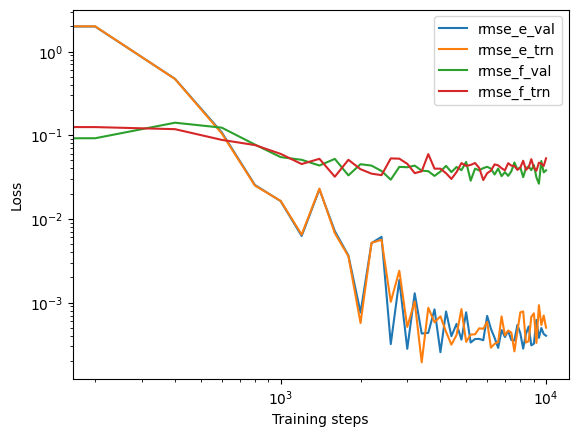

In [ ]:
with open("01.train/lcurve.out") as f:
    headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt("01.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
    plt.loglog(lcurve["step"], lcurve[legend], label=legend)
#     plt.plot(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.Teat a model 

In [30]:
label=0

training_systems = dpdata.LabeledSystem(f"00.data/abacus_md/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"01.train/graph.pb")

As shown later, ABACUS data contains "virials", but OpenMX doesn't.

In [31]:
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 161
Atom Numbers       : 5
Including Virials  : Yes
Element List       :
-------------------
H  C
4  1

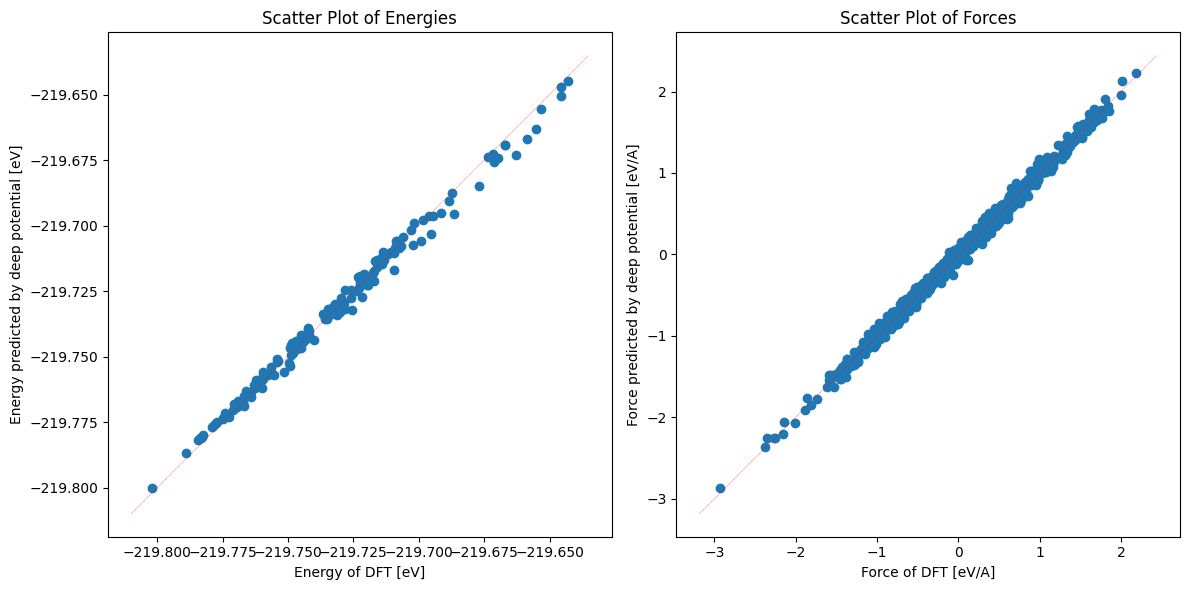

In [33]:
plt.figure(figsize=(12, 6))

# 1つ目のプロット
plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT [eV]")
plt.ylabel("Energy predicted by deep potential [eV]")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.scatter(training_systems["forces"], predict["forces"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Force of DFT [eV/A]")
plt.ylabel("Force predicted by deep potential [eV/A]")
plt.title('Scatter Plot of Forces')

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()

### 6.Run MD with ASE

Please check line 41 of `CH4_MD.py`. This line defines the potential.

In [19]:
if os.path.exists(f"log/abacus_nn.log"):
    os.remove(f"log/abacus_nn.log")

! python3 CH4_MD.py > abacus_nn.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-28 16:47:34.672637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [20]:
filename="abacus_nn"

df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.000,-43.8980,-43.9597,0.0617,477.4
1,0.001,-43.8770,-43.9490,0.0720,557.3
2,0.002,-43.8896,-43.9302,0.0406,314.1
3,0.003,-43.8912,-43.9193,0.0280,216.9
4,0.004,-43.8860,-43.9188,0.0329,254.2
...,...,...,...,...,...
196,0.196,-43.8967,-43.9376,0.0409,316.5
197,0.197,-43.8993,-43.9419,0.0426,329.4
198,0.198,-43.9032,-43.9427,0.0395,305.4
199,0.199,-43.9035,-43.9398,0.0363,280.5


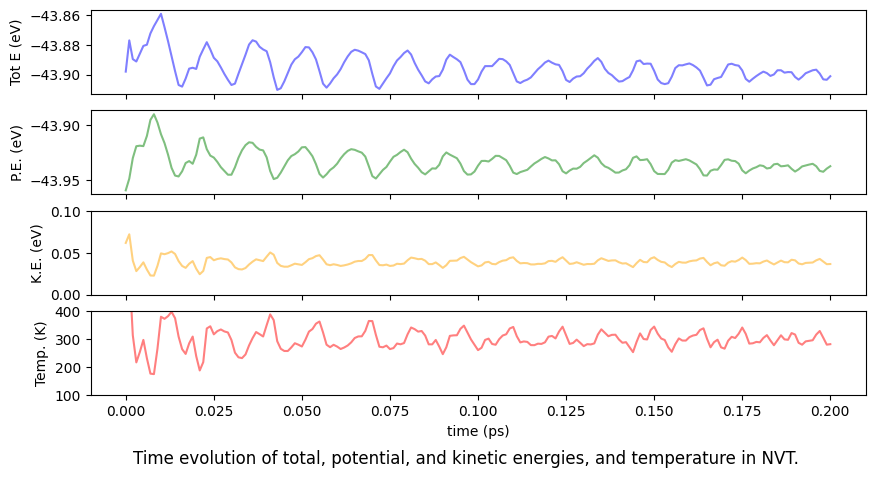

In [21]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

length mean value = 1.10, angle mean value = 109.37


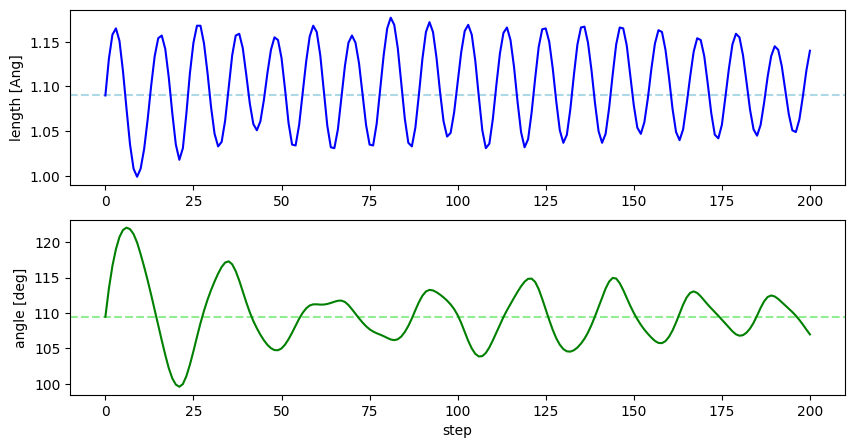

In [22]:
data=np.genfromtxt("abacus_nn.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,5], color="green")

print(f"length mean value = {data[20:,1].mean():1.2f}, angle mean value = {data[20:,5].mean():3.2f}")
# plt.savefig("geometry/abacus_nn.png")
plt.show()

## The demonstration with OpenMX
Please compare learning results from ABCUS and OpenMX to verify that the DeePMD-kit is functioning properly. (OpenMX data does not contain "virials")

### 1.Get DFT data
Place the results of calculations by OpenMX in the directory named `10.data`.

#### Note: Because of __GGA-PBE__, bond length is a little longer than real.

Input file “CH4.dat ”:
```

#
# MD or Geometry Optimization
#

MD.Type                  NVT_NH        # Nomd|Opt|NVE|NVT_VS|NVT_NH
MD.maxIter                  200        # default=1
MD.TimeStep                 1.0        # default=0.5 (fs)
NH.Mass.HeatBath           30.0        # default = 20.0

<MD.TempControl
  2
  1    300.0
  100  300.0
MD.TempControl>
```

length mean value = 1.10, angle mean value = 109.43


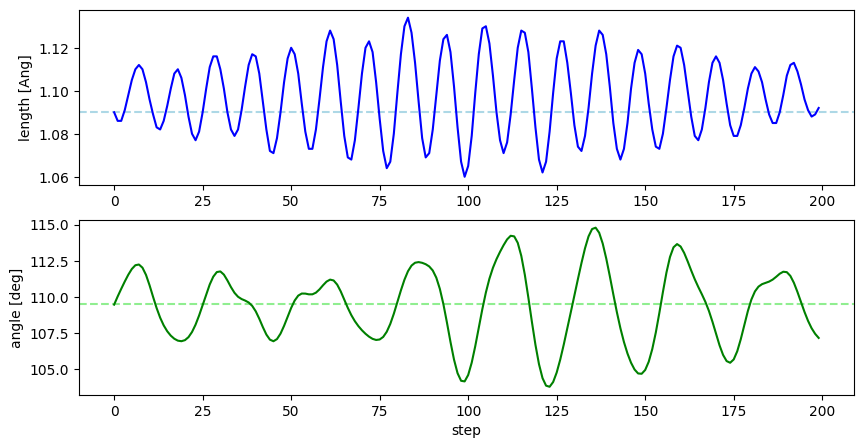

In [23]:
### OpenMX data plot ###
data=np.genfromtxt("openmx.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,5], color="green")

print(f"length mean value = {data[:,1].mean():1.2f}, angle mean value = {data[:,5].mean():3.2f}")
# plt.savefig("geometry/openmx.png")
plt.show()

### 2.Data preparation

The variable named label is the number which identifies data directories. This variable is used to distinguish data.

In [14]:
label=1

In [14]:
data = dpdata.LabeledSystem(f'{label}0.data/Methane', fmt = 'openmx')
print('# the data contains %d frames' % len(data))

# random choose 40 index for validation_data
index_validation = np.random.choice(len(data),size=40,replace=False)     

# other indexes are training_data
index_training = list(set(range(len(data)))-set(index_validation))       
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# all training data put into directory:"training_data" 
data_training.to_deepmd_npy(f'{label}0.data/training_data')      

# all validation data put into directory:"validation_data"
data_validation.to_deepmd_npy(f'{label}0.data/validation_data')

print('# the training data contains %d frames' % len(data_training)) 
print('# the validation data contains %d frames' % len(data_validation))

# the data contains 200 frames
# the training data contains 160 frames
# the validation data contains 40 frames


In [127]:
training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

In [128]:
training_systems # not include virials

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 5
Including Virials  : No
Element List       :
-------------------
C  H
1  4

### 3.Prepare input script

Input file “input.json ”:
```
"model": {
        "type_map":	["H", "C"],
        "descriptor" :{
            "type":		"se_e2_a",
            "sel":		"auto",
            "rcut_smth":	0.50,
            "rcut":		6.00,
            "neuron":		[25, 50, 100],
            "resnet_dt":	false,
            "axis_neuron":	16,
            "seed":		1,
            "_comment":		" that's all"
        },
        "fitting_net" : {
            "neuron":		[240, 240, 240],
            "resnet_dt":	true,
            "seed":		1,
            "_comment":		" that's all"
        },
```

In [25]:
! cat 11.train/input.json

{
      "_comment": " model parameters",
      "model": {
        "type_map":	["H", "C"],
        "descriptor" :{
            "type":		"se_e2_a",
            "sel":		"auto",
            "rcut_smth":	0.50,
            "rcut":		6.00,
            "neuron":		[25, 50, 100],
            "resnet_dt":	false,
            "axis_neuron":	16,
            "seed":		1,
            "_comment":		" that's all"
        },
        "fitting_net" : {
            "neuron":		[240, 240, 240],
            "resnet_dt":	true,
            "seed":		1,
            "_comment":		" that's all"
        },
        "_comment":	" that's all"
      },
  
      "learning_rate" :{
        "type":		"exp",
        "decay_steps":	50,
        "start_lr":	0.001,	
        "stop_lr":	3.51e-8,
        "_comment":	"that's all"
      },
  
      "loss" :{
        "type":		"ener",
        "start_pref_e":	0.02,
        "limit_pref_e":	1,
        "start_pref_f":	1000,
        "limit_pref_f":	1,
        "start_pref_v":	0,
        "limit_pr

### 4.Train a model
After the training script is prepared, we can start the training with DeePMD-kit by simply running

In [26]:
! dp neighbor-stat -s 10.data -r 6.0 -t H C

Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    training data with min nbor dist: 1.029958484357501
DEEPMD INFO    training data with max nbor size: [4 1]
DEEPMD INFO    min_nbor_dist: 1.029958
DEEPMD INFO    max_nbor_size: [4 1]


In [11]:
### Execute the deepmd-kit commands in sequence.　###
! sed -i '' 's/label=0/label=1/g' train.sh
! bash train.sh

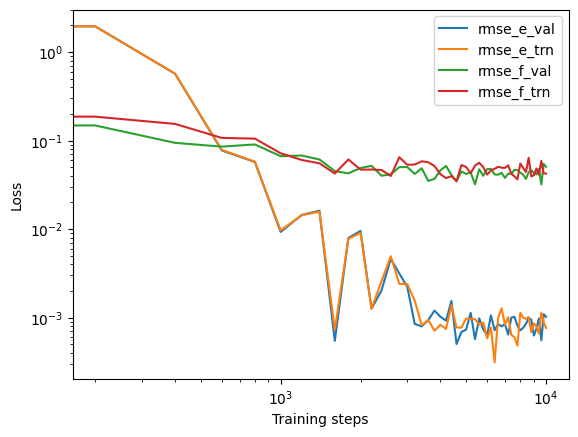

In [28]:
with open(f"{label}1.train/lcurve.out") as f:
      headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt(f"{label}1.train/lcurve.out"), columns=headers)
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
for legend in legends:
      plt.loglog(lcurve["step"], lcurve[legend], label=legend)
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 5.Test a model
The terminal should display the following

```
DEEPMD INFO    # ---------------output of dp test--------------- 
DEEPMD INFO    # testing system : ../10.data/validation_data
DEEPMD INFO    # number of test data : 40 
DEEPMD INFO    Energy MAE         : 2.009603e-02 eV
DEEPMD INFO    Energy RMSE        : 1.047193e-01 eV
DEEPMD INFO    Energy MAE/Natoms  : 4.019206e-03 eV
DEEPMD INFO    Energy RMSE/Natoms : 2.094386e-02 eV
DEEPMD INFO    Force  MAE         : 7.936626e-02 eV/A
DEEPMD INFO    Force  RMSE        : 4.051071e-01 eV/A
DEEPMD INFO    Virial MAE         : 7.100587e-01 eV
DEEPMD INFO    Virial RMSE        : 9.135305e-01 eV
DEEPMD INFO    Virial MAE/Natoms  : 1.420117e-01 eV
DEEPMD INFO    Virial RMSE/Natoms : 1.827061e-01 eV
DEEPMD INFO    # ----------------------------------------------- 
```

In [27]:
label=1

training_systems = dpdata.LabeledSystem(f"{label}0.data/training_data", fmt="deepmd/npy")

predict = training_systems.predict(f"{label}1.train/graph.pb")

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-11-28 17:03:27.905558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [28]:
training_systems

Data Summary
Labeled System
-------------------
Frame Numbers      : 160
Atom Numbers       : 5
Including Virials  : No
Element List       :
-------------------
C  H
1  4

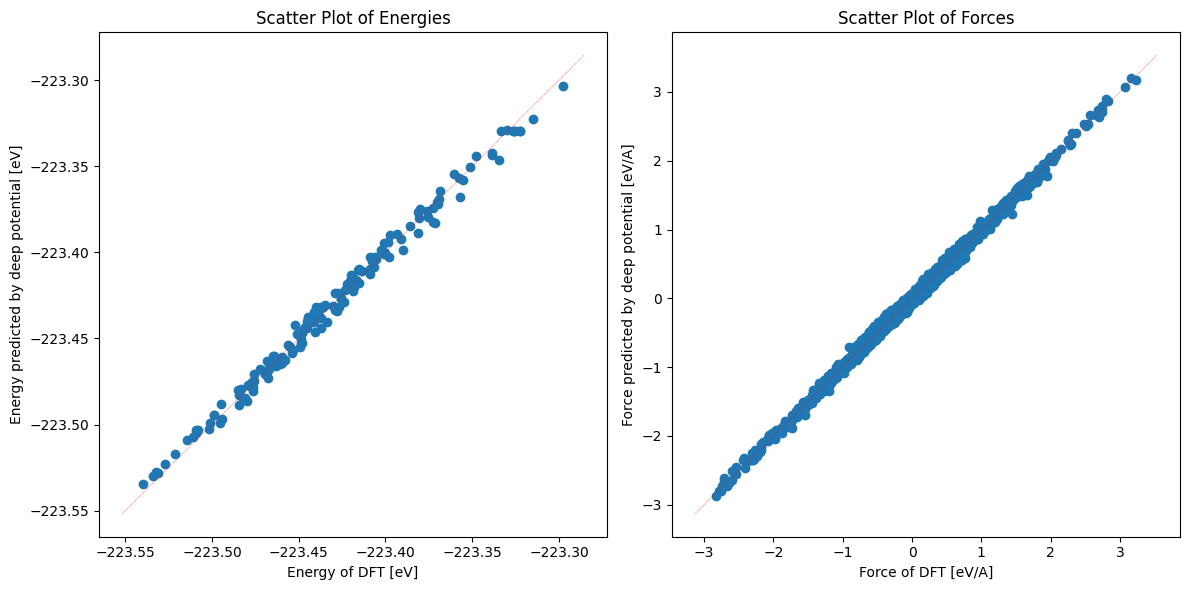

In [29]:
plt.figure(figsize=(12, 6))

# 1つ目のプロット
plt.subplot(1, 2, 1)  # 1行2列の1番目のサブプロット
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Energy of DFT [eV]")
plt.ylabel("Energy predicted by deep potential [eV]")
plt.title('Scatter Plot of Energies')

# 2つ目のプロット
plt.subplot(1, 2, 2)  # 1行2列の2番目のサブプロット
plt.scatter(training_systems["forces"], predict["forces"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)
plt.xlabel("Force of DFT [eV/A]")
plt.ylabel("Force predicted by deep potential [eV/A]")
plt.title('Scatter Plot of Forces')

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()


### 6.Run MD with ASE

In [35]:
filename="openmx_nn"

In [40]:
if os.path.exists(f"log/{filename}.log"):
    os.remove(f"log/{filename}.log")

! python3 CH4_MD.py > openmx_nn.txt

Instructions for updating:
non-resource variables are not supported in the long term
2023-11-27 02:21:03.273565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/opt/homebrew/lib/python3.11/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [41]:
df = pd.read_csv(
    f"log/{filename}.log",
    delim_whitespace=True,
    names=["Time[ps]", "Etot/N[eV]", "Epot/N[eV]", "Ekin/N[eV]", "T[K]"],
    skiprows=1,
    header=None,
)
df

,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K]
0,0.000,-44.6378,-44.7098,0.0720,556.7
1,0.001,-44.6047,-44.7013,0.0967,747.8
2,0.002,-44.6225,-44.6838,0.0613,474.2
3,0.003,-44.6339,-44.6680,0.0341,264.1
4,0.004,-44.6292,-44.6561,0.0268,207.4
...,...,...,...,...,...
196,0.196,-44.6563,-44.6984,0.0421,326.0
197,0.197,-44.6595,-44.6980,0.0385,297.7
198,0.198,-44.6590,-44.6952,0.0362,280.1
199,0.199,-44.6564,-44.6932,0.0368,284.6


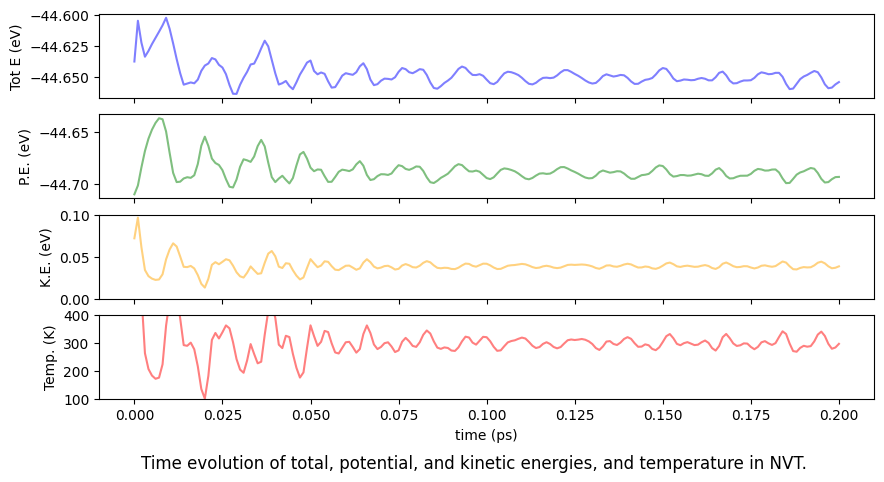

In [42]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])  # x axis label
ax1.set_ylabel('Tot E (eV)')  # y axis label
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])  # x axis label
ax2.set_ylabel('P.E. (eV)')  # y axis label
ax2.plot(df["Time[ps]"], df["Epot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])  # x axis label
ax3.set_ylabel('K.E. (eV)')  # y axis label
ax3.set_ylim([0.0, 0.1])
ax3.plot(df["Time[ps]"], df["Ekin/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')  # x axis label
ax4.set_ylabel('Temp. (K)')  # y axis label
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)
ax4.set_ylim([100., 400])

fig.suptitle("Time evolution of total, potential, and kinetic energies, and temperature in NVT.", y=0)

plt.show()

#### Focusing on a single bond length and bond angle, we obtain the following graph.

length mean value = 1.10, angle mean value = 109.23


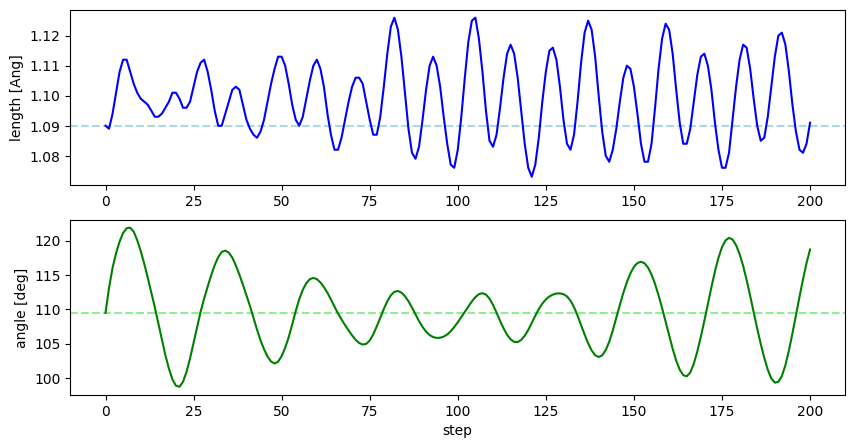

In [50]:
data=np.genfromtxt(f"{filename}.txt")

fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(2, 1, 1)
# plt.xlim(200,800)
ax1.set_ylabel('length [Ang]')  # y axis label
ax1.axhline(1.09,color="lightblue",linestyle="--")
ax1.plot(data[:,0], data[:,1], color="blue")

ax2 = fig.add_subplot(2, 1, 2)
# plt.xlim(200,800)
ax2.set_xlabel("step")
ax2.set_ylabel('angle [deg]')  # y axis label
ax2.axhline(109.5,color="lightgreen",linestyle="--")
ax2.plot(data[:,0], data[:,4], color="green")

print(f"length mean value = {data[20:,1].mean():1.2f}, angle mean value = {data[20:,4].mean():3.2f}")
# plt.savefig(f"geometry/{filename}.png")
plt.show()

### 7.Run Structure optimization with ASE

      Step     Time          Energy         fmax
BFGS:    0 15:00:40     -212.716497       12.9935
length[Å] length[Å] length[Å] length[A] angle[deg] angle[deg] angle[deg]
0.469   0.469   0.469   129.521   100.476   100.476
BFGS:    1 15:00:40     -215.158951        6.7391
length[Å] length[Å] length[Å] length[A] angle[deg] angle[deg] angle[deg]
0.297   0.297   0.464   109.487   77.684   77.684
BFGS:    2 15:00:40     -215.545451        6.8381
length[Å] length[Å] length[Å] length[A] angle[deg] angle[deg] angle[deg]
0.353   0.353   0.456   119.573   77.895   77.895
BFGS:    3 15:00:40     -215.450798        8.2718
length[Å] length[Å] length[Å] length[A] angle[deg] angle[deg] angle[deg]
0.413   0.413   0.518   159.283   82.705   82.705
BFGS:    4 15:00:40     -216.395816       50.4682
length[Å] length[Å] length[Å] length[A] angle[deg] angle[deg] angle[deg]
0.456   0.456   0.583   149.563   78.547   78.547
BFGS:    5 15:00:40     -215.742474        9.3244
length[Å] length[Å] length[Å] leng

/opt/homebrew/lib/python3.11/site-packages/ase/visualize/plot.py:59: UserWarning: You passed in an explicit save_count=100 which is being ignored in favor of len(frames)=57.
  animation = FuncAnimation(fig, drawimage, frames=images,


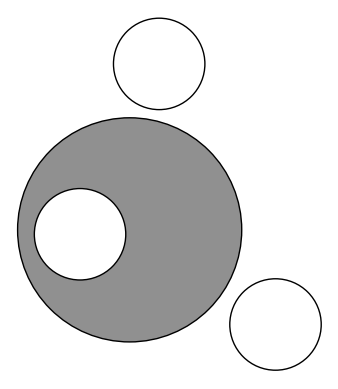

In [ ]:
from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.emt import EMT
from deepmd.calculator import DP
import numpy as np
from ase.md import MDLogger
from ase.io import write,Trajectory
a = 0.30 ## 0.9584
b = 0.20
methane = Atoms('CH4',
              positions=[(0.0, 0.0, 0.0),
                         (-a,  a,  b),
                         ( a, -a,  b),
                         ( a,  a, -b),
                         (-a, -a,  b)])
label=1
methane.set_calculator(DP(model=f"{label}1.train/graph.pb"))
dyn = BFGS(methane, trajectory="CH4.traj")

def calculate_angle(v1, v2):
    # ベクトルv1とv2の内積を計算
    dot_product = np.dot(v1, v2)
    
    # ベクトルv1とv2のノルムを計算
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # アークコサインを使用して角度を計算
    angle_rad = np.arccos(dot_product / (norm_v1 * norm_v2))
    
    # ラジアンから度に変換
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def myprint():
    vec1=methane.positions[0]-methane.positions[1]
    vec2=methane.positions[0]-methane.positions[2]
    vec3=methane.positions[0]-methane.positions[3]
    print("length[Å] length[Å] length[Å] length[A] angle[deg] angle[deg] angle[deg]")
    print(f'{np.linalg.norm(vec1):5.3f}   '+f'{np.linalg.norm(vec2):5.3f}   '+f'{np.linalg.norm(vec3):5.3f}   '+f'{calculate_angle(vec1,vec2):5.3f}   '+f'{calculate_angle(vec2,vec3):5.3f}   '+f'{calculate_angle(vec3,vec1):5.3f}')

dyn.attach(myprint, interval=1)
dyn.run(fmax=0.05)
traj=Trajectory("CH4.traj")
write(f"CH4.gif", traj[::1], rotation="30x,30y,30z")

## 【Known problems】

### AssertionError

```
<Atoms.UnitVectors
     -3.5600000     0.0000000     3.5600000
      0.0000000     3.5600000     3.5600000
     -3.5600000     3.5600000     0.0000000
Atoms.UnitVectors>
```
has no problem, but
```
<Atoms.UnitVectors
     3.5600000     0.0000000     3.5600000
     0.0000000     3.5600000     3.5600000
     3.5600000     3.5600000     0.0000000
Atoms.UnitVectors>
```
makes a bug.

```
  File "dpdata/system.py", line 672, in rot_frame_lower_triangular
    assert np.linalg.det(rot) == 1
           ^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
```

#### The cause of this error will be investigated later.

## 【Linkage to tools】

1. [OpenMX](https://www.openmx-square.org/)
1. [DeePMD-kit](https://github.com/deepmodeling/deepmd-kit)
1. [ASE](https://wiki.fysik.dtu.dk/ase/)